<a href="https://colab.research.google.com/github/xianyummy/C-projects/blob/main/image_classification_with_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook comes from this tutorial [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/). I have only modified the hyperparameters to train the underlying model on the CIFAR-10 dataset.

## Setup

In [1]:
!pip install -U tensorflow-addons
!pip uninstall tensorflow tensorflow-addons -y
!pip install tensorflow==2.15.0
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
Found existing installation: tensorflow-addons 0.23.0
Uninstalling tensorflow-addons-0.23.0:
  Successfully uninstalled tensorflow-addons-0.23.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.8 

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Prepare the data

In [3]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
print(f"Unique labels in y_train: {np.unique(y_train)}")


170498071/170498071 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Unique labels in y_train: [0 1 2 3 4 5 6 7 8 9]


## Configure the hyperparameters

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 200
image_size = 32
patch_size = 4  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 48
num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 2
mlp_head_units = [projection_dim * 4, projection_dim * 2]  # Size of the dense layers of the final classifier


## Use data augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Rescaling(scale=1./255),
        layers.experimental.preprocessing.RandomCrop(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal")
    ],
    name="data_augmentation"
)

## Implement multilayer perceptron (MLP)

In [6]:

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


## Implement patch creation as a layer

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size,**kwargs):
        super(Patches, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'patch_size': self.patch_size
        })
        return config


Let's display patches for a sample image

Image size: 32 X 32
Patch size: 4 X 4
Patches per image: 64
Elements per patch: 48


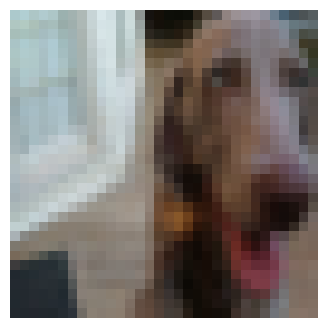

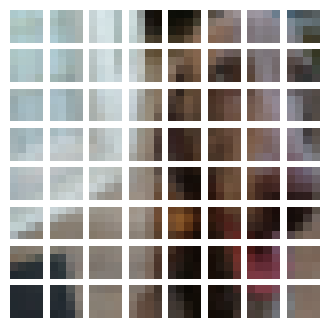

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")
plt.savefig("original.png", dpi=300, bbox_inches="tight")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
plt.savefig("patched.png", dpi=300, bbox_inches="tight")

## Implement the patch encoding layer

The `PatchEncoder` layer will linearly transform a patch by projecting it into a
vector of size `projection_dim`. In addition, it adds a learnable position
embedding to the projected vector.

In [9]:

"""class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
    def get_config(self):
        config = super().get_config().copy()
        config.update({
        "num_patches": self.num_patches,
        "projection": self.projection,
        "position_embedding": self.position_embedding,
        })
        return config"""
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super(PatchEncoder, self).__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_patches': self.num_patches,
            'projection_dim': self.projection.units  # 存儲投影維度而不是層對象
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)



## Build the ViT model

In [10]:

def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.6)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model
model=create_vit_classifier()
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 data_augmentation (Sequent  (None, 32, 32, 3)            0         ['input_1[0][0]']             
 ial)                                                                                             
                                                                                                  
 patches_1 (Patches)         (None, None, 48)             0         ['data_augmentation[0][0]']   
                                                                                                  
 patch_encoder (PatchEncode  (None, 64, 48)               5424      ['patches_1[0][0]']       

In [11]:
create_vit_classifier().count_params()/1e6

0.662362

## Compile, train, and evaluate the mode

In [ ]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/100
704/704 [==============================] - 17s 16ms/step - loss: 2.3235 - accuracy: 0.0992 - top-5-accuracy: 0.4926 - val_loss: 2.3031 - val_accuracy: 0.0986 - val_top-5-accuracy: 0.4928
Epoch 2/100
704/704 [==============================] - 10s 14ms/step - loss: 2.3030 - accuracy: 0.0987 - top-5-accuracy: 0.4994 - val_loss: 2.3028 - val_accuracy: 0.0976 - val_top-5-accuracy: 0.4932
Epoch 3/100
704/704 [==============================] - 18s 25ms/step - loss: 2.3030 - accuracy: 0.0988 - top-5-accuracy: 0.4994 - val_loss: 2.3033 - val_accuracy: 0.0986 - val_top-5-accuracy: 0.4840
Epoch 4/100
704/704 [==============================] - 10s 14ms/step - loss: 2.3032 - accuracy: 0.0975 - top-5-accuracy: 0.4937 - val_loss: 2.3029 - val_accuracy: 0.0976 - val_top-5-accuracy: 0.4898
Epoch 5/100
704/704 [==============================] - 11s 16ms/step - loss: 2.3029 - accuracy: 0.0990 - top-5-accuracy: 0.4972 - val_loss: 2.3030 - val_accuracy: 0.0986 - val_top-5-accuracy: 0.4994
Epoch

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

In [ ]:
vit_classifier.save('my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model

custom_objects = {
    'Patches': Patches,
    'PatchEncoder': PatchEncoder  # 加入 PatchEncoder 類
}
loaded_model = load_model('my_model.h5', custom_objects=custom_objects)

model.trainable_variables
for var in model.trainable_variables:
    print(f"{var.name}: {var.shape}")

# 測試模型
results = loaded_model.evaluate(x_test, y_test)
print("Test accuracy:", results[1])
